In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm

In [63]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.where(x>0,x,0)

def softmax(x):
    m = np.max(x,1).reshape(-1,1)
    c = x - m
    return np.exp(c)/np.sum(np.exp(c),1).reshape(-1,1)

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [64]:
def rmse(y,y_hat):
    return np.sqrt(np.mean(np.square(y-y_hat))) 

def binary_crossentropy(y,y_hat):
    epsilon = 1e-7
    return -np.mean((1-y)*np.log(1-y_hat+epsilon)+y*np.log(y_hat+epsilon))

def categorical_crossentropy(y_hat,y):
    epsilon = 1e-7
    return -np.mean(y*np.log(y_hat+epsilon))

In [65]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self,x):
        return sigmoid(x)
    
    def backward(self,out):
        dout = sigmoid(out)*(1-sigmoid(out))
        return dout

In [66]:
class ReLU:
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        out = relu(x)
        self.out = np.where(out>0,1,0)
        return out
        
    def backward(self,out):
        dout = self.out*out
        return dout

In [67]:
class Affine:
    def __init__(self,w,b):
        self.x = None
        self.w = w
        self.b = b
    
    def forward(self,x):
        self.x = x
        self.out = np.dot(self.x,self.w) + self.b
        return self.out
    
    def backward(self,out):
        self.dout = np.dot(out,self.w.T)#4,2
        self.dW = np.dot(self.x.T,out)#2,5
        self.db = np.sum(out,axis=0)#5
        return self.dout    

In [68]:
class Tanh:
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        return tanh(x)
    
    def backward(self,out):
        dout = 1 - tanh(out)**2
        return dout

In [95]:
class SoftmaxWithLoss:
    def __init__(self):
        self.out = None
        self.y = None
        self.y_hat = None
        
    def forward(self,x,y):
        self.y = y
        self.y_hat = softmax(x)
        self.loss_val = categorical_crossentropy(self.y,self.y_hat)
        return self.loss_val
    
    def backward(self):
        self.dout = (self.y_hat - self.y)/len(self.y)
        return self.dout

In [9]:
def sigdiff(x):
    return sigmoid(x) * (1-sigmoid(x))

def tanhdiff(x):
    return 1-tanh(x)**2

In [10]:
s = Sigmoid()

In [11]:
x = np.random.randn(3,2)
w = np.random.randn(2,2)

In [12]:
out = np.dot(s.forward(x),w)
s.forward(x), s.backward(out)

(array([[0.01348314, 0.19270431],
        [0.24322684, 0.64309884],
        [0.74161916, 0.24855469]]),
 array([[0.31848006, 0.32705802],
        [0.29355916, 0.36379977],
        [0.16561435, 0.34116047]]))

In [13]:
r = ReLU()

In [14]:
x = np.array([[-5,6],[2,0],[-1,3]])
dx = np.array([[100,-5],[-7,-3],[7,10]])

In [15]:
r.forward(x), r.backward(dx)

(array([[0, 6],
        [2, 0],
        [0, 3]]),
 array([[ 0, -5],
        [-7,  0],
        [ 0, 10]]))

In [16]:
x = np.random.randn(4,2)
w = np.random.randn(2,5)
b = np.zeros(5)

In [17]:
a = Affine(w,b)

In [18]:
a.forward(x)

array([[ 3.10954358,  3.20856106, -0.57993534,  0.19699781, -1.33817084],
       [-1.81042747, -1.81785128,  0.35865086, -0.12928546,  0.77562254],
       [ 1.24214824,  0.11977811, -0.71754543,  0.41622065, -0.45398462],
       [-1.0508482 , -0.48086165,  0.44832967, -0.24186985,  0.41038346]])

In [19]:
a.backward(a.forward(x))

array([[ -9.98072567, -12.51226649],
       [  5.80291762,   7.20278853],
       [ -3.80127789,  -3.0998358 ],
       [  3.27649508,   3.24251556]])

In [20]:
sm = SoftmaxWithLoss()

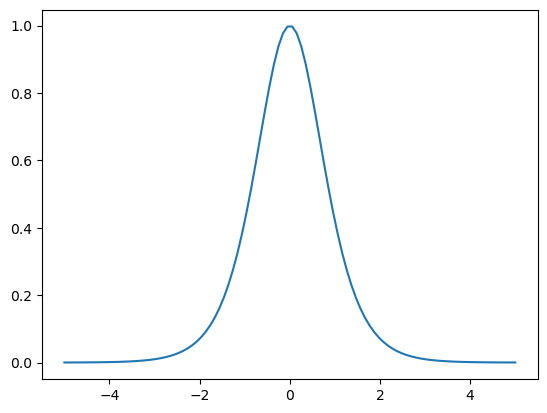

In [21]:
x = np.linspace(-5,5,100)
y = tanhdiff(x)
plt.plot(x,y)

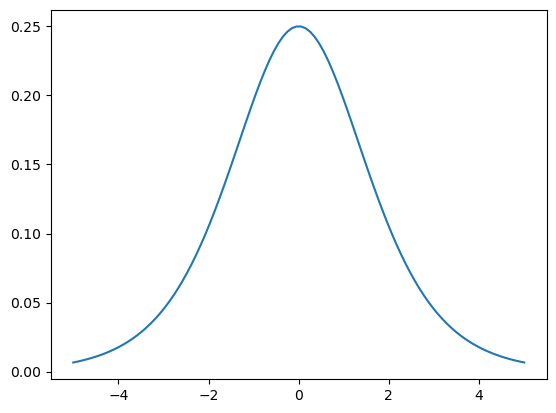

In [22]:
x = np.linspace(-5,5,100)
y = sigdiff(x)
plt.plot(x,y)

In [23]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras import activations
# from tensorflow.keras.layers import ReLU
# from tensorflow.keras.optimizers import Adam
# model = Sequential()
# model.add(Dense(100,activation='relu',input_shape=(784,)))
# model.add(Dense(10,activation='sigmoid'))
# opt = Adam(lr=1e-4)

In [150]:
class Net:
    def __init__(self,input_shape):
        self.x = None
        self.y = None
        self.input_shape = input_shape
        self.layers = []
        self.activation_dic = {
            'relu':ReLU,
            'sigmoid':Sigmoid,
            'softmax':SoftmaxWithLoss,
            'tanh':Tanh
        }
        self.grad = None
        
    def add(self,output_shape,activation):
        if len(self.layers) == 0:
            w = np.random.randn(self.input_shape,output_shape)
            b = np.zeros(output_shape)
            activation = self.activation_dic.get(activation)
            self.layers.append([w,b,activation])
        else:
            input_shape = self.layers[-1][0].shape[1]
            w = np.random.randn(input_shape,output_shape)
            b = np.zeros(output_shape)
            activation = self.activation_dic.get(activation)
            self.layers.append([w,b,activation])
    
    def _build(self):
        self.W = {}
        for i, layer in enumerate(self.layers,1):
            w = layer[0]
            b = layer[1]
            activation = layer[2]
            self.W['Affine_'+str(i)] = Affine(w,b)
            self.W['Activation_'+str(i)] = activation()
        return f'Building Success'
    
    def compile(self,lr,loss,metrics):
        loss_func_dic = {
            'rmse':rmse,
            'binary_crossentorpy':binary_crossentropy,
            'categorical_crossentropy':categorical_crossentropy
        } 
        
        metrics_dic ={
            'accuracy':'accuracy',
            'rmse':'rmse'
        }
        
        self.loss_func = loss_func_dic[loss]
        self.metrics = metrics_dic[metrics]
        self.lr = lr
        
    def train(self,x,y):
        if self.grad == None:
            self._build()
        self.y = y
        self.y_hat = x

        for layer in list(self.W.items())[:-1]:
            self.y_hat = layer[1].forward(self.y_hat)
        self.loss_val = list(self.W.items())[-1][1].forward(self.y_hat,self.y)
        return self.y_hat, self.loss_val
    
    def predict(self,x):
        self.y_hat = x
        for layer in list(self.W.items())[:-1]:
            self.y_hat = layer[1].forward(self.y_hat)
        self.y_hat = softmax(self.y_hat)
        return self.y_hat
    
    def evaluate(self,x,y):
        y_hat = self.predict(x)
        loss = categorical_crossentropy(y_hat,y)
        accuracy = np.sum(np.argmax(y_hat,1) == np.argmax(y,1))/len(y)
        # print(f' loss : {loss}, accuracy : {np.around(accuracy,2)}')
        return [loss, accuracy]
    
    def gradient(self,x,y):
        self.y_hat = self.train(x,y)[0]
        self.y = y
        self.grad = {}
        last_layer = list(self.W.keys())[-1]
        out = self.W.get(last_layer).backward()
        for key in list(self.W.keys())[-2::-1]:
            out = self.W.get(key).backward(out)
        
        idx = 1
        for key in self.W.keys():
            if 'Affine' in key:
                self.grad['W'+str(idx)] = self.W.get(key).dW
                self.grad['b'+str(idx)] = self.W.get(key).db
                idx += 1
                
        return self.grad
        
    def loss(self,x,y):
        y_hat, loss_val = self.predict(x,y)
        # loss_val = categorical_crossentropy(y_hat,y)
        accuracy = np.sum(np.argmax(y_hat,1) == np.argmax(y,1))/len(y)
        return [accuracy, loss_val] 
    
    def summary(self):
        total_params = 0
        if self.grad == None:
            self._build()
        print("----------------------------------------------")
        print("                Output Shape           Param #")
        print("==============================================")
        for idx, layer in enumerate(self.layers,1):
            tmp_length = 20 - len(str(layer[0].shape[1]))
            print(f'Affine_{idx}        (None, {layer[0].shape[1]}) {np.prod(layer[0].shape) + layer[0].shape[1]:>{tmp_length}}')
            total_params += np.prod(layer[0].shape) + layer[0].shape[1]
        print("==============================================")
        print(f"total params: {total_params}")
    
    def fit(self,x,y,epochs=10):
        for epoch in range(epochs):
            self.grad = self.gradient(x,y)
            evaluate = self.evaluate(x,y)
            print(f'{epoch+1} ================> accuracy : {np.around(evaluate[1],2)}, loss : {evaluate[0]}')
            # print(f'{epoch+1} ====================> accuracy : {self.evaluate(x,y)[1]} loss : {self.evaluate(x,y)[0]}')
            for idx, _ in enumerate(self.layers,1):
                self.W.get('Affine_'+str(idx)).w -= self.lr*self.grad['W'+str(idx)]
                self.W.get('Affine_'+str(idx)).b -= self.lr*self.grad['b'+str(idx)]

In [138]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [139]:
X_train = X_train.reshape(-1,784) / 255.0
X_test = X_test.reshape(-1,784) / 255.0

In [140]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [169]:
model = Net(784)

In [170]:
model.add(256,activation='relu')
model.add(64,activation='relu')
model.add(10,activation='softmax')

In [171]:
model.compile(lr = 1e-2, loss='categorical_crossentropy', metrics='accuracy')

In [172]:
model.fit(X_train, y_train,epochs=100)

1 ================> accuracy : 0.15, loss : 1.3662401383879885
2 ================> accuracy : 0.17, loss : 1.3282609912488093
3 ================> accuracy : 0.24, loss : 1.2195978746415672
4 ================> accuracy : 0.23, loss : 1.2400150586761267
5 ================> accuracy : 0.28, loss : 1.1462156887794448
6 ================> accuracy : 0.26, loss : 1.1789292293787281
7 ================> accuracy : 0.32, loss : 1.0531420285963689
8 ================> accuracy : 0.36, loss : 0.9857090789569832
9 ================> accuracy : 0.38, loss : 0.9348969504473446
10 ================> accuracy : 0.4, loss : 0.9006267617031772
11 ================> accuracy : 0.41, loss : 0.8718575402840004
12 ================> accuracy : 0.42, loss : 0.847456942701467
13 ================> accuracy : 0.43, loss : 0.827374644405553
14 ================> accuracy : 0.43, loss : 0.8048508236431978
15 ================> accuracy : 0.44, loss : 0.7946244692598065
16 ================> accuracy : 0.45, loss : 0.77442

In [164]:
from tensorflow.keras.datasets import fashion_mnist

In [168]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(-1,784) / 255.0
X_test = X_test.reshape(-1,784) / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [173]:
fashion_dic = {0 : "T-shirt/top",
1 : "Trouser",
2 : "Pullover",
3 : "Dress",
4 : "Coat",
5 : "Sandal",
6 : "Shirt",
7 : "Sneaker",
8 : "Bag",
9 : "Ankle boot"}

In [174]:
fashion_dic

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [177]:
number = [6,28,134,55,79,88,112,49,22,813]

data = X_test[number,:]
data = data.reshape(-1,28,28)

In [156]:
import matplotlib.pyplot as plt

In [106]:
data[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [107]:
data[[0]].reshape(-1,784)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [158]:
pred, _ = model.train(data[[0]].reshape(-1,784),np.random.randn(1,10))

C:\Users\user\AppData\Local\Temp\ipykernel_15272\1109246927.py:10: RuntimeWarning: invalid value encountered in log
  return -np.mean(y*np.log(y_hat+epsilon))


In [159]:
pred  = np.argmax(pred,1)[0]

예측값은 : Bag


C:\Users\user\AppData\Local\Temp\ipykernel_15272\1109246927.py:10: RuntimeWarning: invalid value encountered in log
  return -np.mean(y*np.log(y_hat+epsilon))


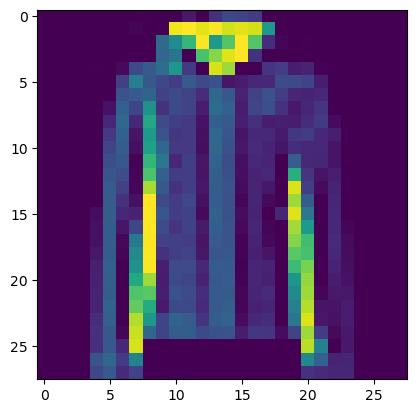

예측값은 : Ankle boot


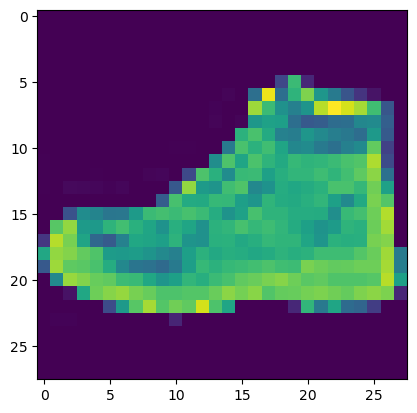

예측값은 : Shirt


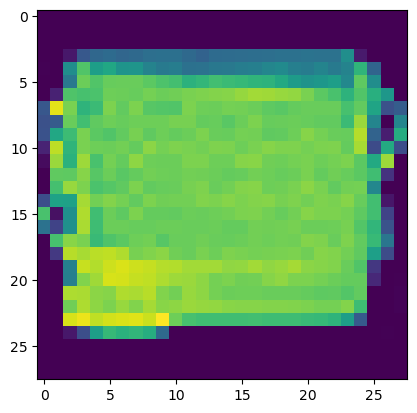

예측값은 : Shirt


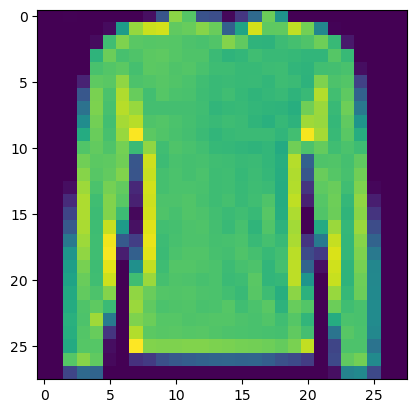

예측값은 : Shirt


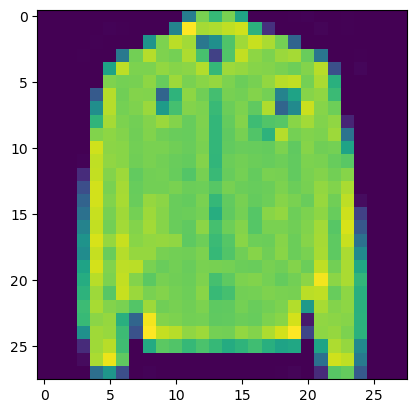

예측값은 : Dress


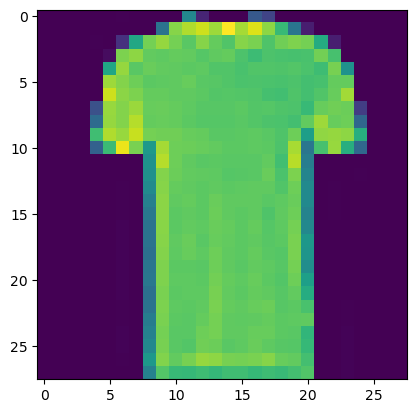

예측값은 : Sneaker


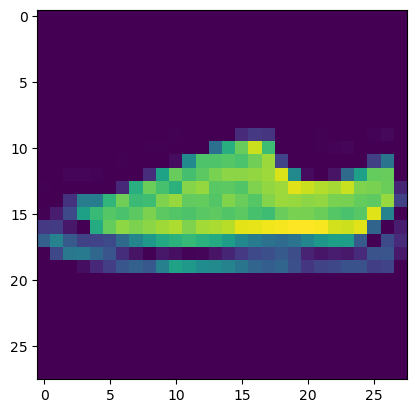

예측값은 : Dress


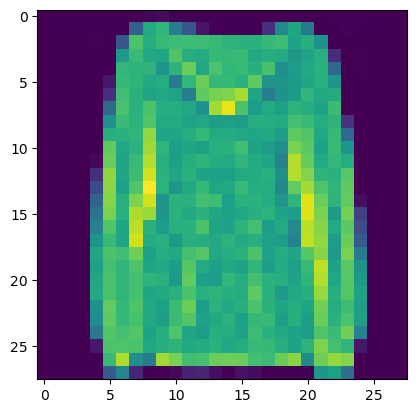

예측값은 : Sneaker


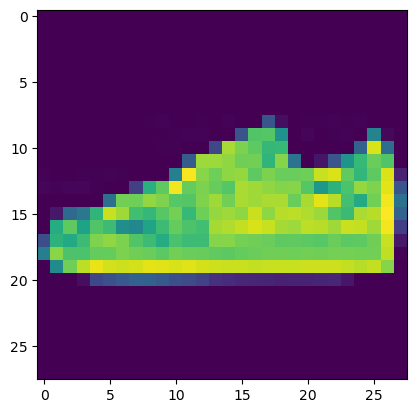

예측값은 : Sandal


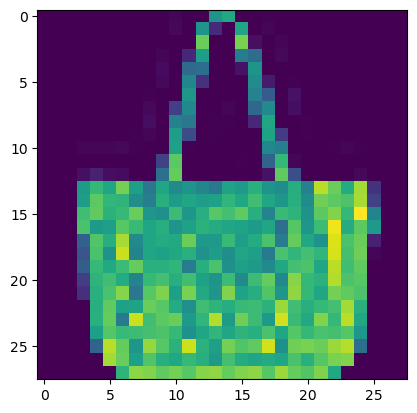

In [178]:
for i in range(len(data)):
    pred, _ = model.train(data[[i]].reshape(-1,784),np.random.randn(1,10))
    pred = np.argmax(pred,1)[0]
    print(f'예측값은 : {fashion_dic[pred]}')
    plt.imshow(data[i])
    plt.show()

In [183]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [182]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [189]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

In [197]:
model = Sequential(
[
    Flatten(input_shape=input_shape),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(output_shape,activation='softmax')
])

In [198]:
optimizer ='rmsprop'
loss = 'categorical_crossentropy'
metrics = 'accuracy'
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=metrics)

In [199]:
model.fit(X_train,y_train,epochs=10,batch_size=64,validation_data=(X_test,y_test))

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 4.2975 - accuracy: 0.7048 - val_loss: 0.7425 - val_accuracy: 0.7566
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.6697 - accuracy: 0.7947 - val_loss: 0.6419 - val_accuracy: 0.7965
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5929 - accuracy: 0.8176 - val_loss: 0.5610 - val_accuracy: 0.8241
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5782 - accuracy: 0.8273 - val_loss: 0.6334 - val_accuracy: 0.8069
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5527 - accuracy: 0.8332 - val_loss: 1.4150 - val_accuracy: 0.7842
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5788 - accuracy: 0.8334 - val_loss: 0.6290 - val_accuracy: 0.8387
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5622 - accuracy: 0.8359 - val_loss: 0.6200 - val_accuracy: 0.8405
Epoch 

In [25]:
model = Net(10)

In [26]:
model.add(100,activation='relu')

In [27]:
model.summary()

----------------------------------------------
                Output Shape           Param #
Affine_1        (None, 100)              1100
total params: 1100


In [28]:
model.layers

[[array([[-8.01803285e-01, -6.47549271e-01, -1.37228797e+00,
          -6.15383763e-01, -1.94215971e-01, -7.09492352e-01,
           2.28374262e-01, -8.94057742e-01,  1.21892466e+00,
           2.03066241e+00,  1.78462146e+00,  1.34995122e+00,
           1.40222851e+00, -7.12382989e-01,  1.81752628e+00,
           8.52310553e-01, -7.69305608e-01, -6.51079092e-01,
           6.59665514e-01,  4.05752496e-01, -4.98604992e-01,
          -8.67330492e-01,  1.48249407e-01, -1.89101324e+00,
          -6.37963109e-01,  7.42250668e-02, -7.70243437e-01,
           2.60820991e-01,  1.03368894e+00,  7.02227250e-03,
           1.27948359e+00, -5.44494759e-01, -2.19465272e+00,
           6.51305192e-01,  3.69984249e-01, -1.78175232e+00,
          -1.32140574e+00,  9.52343588e-01, -5.13503136e-01,
           1.20121162e-01, -1.15103251e+00,  2.35351873e-01,
           1.27575354e+00,  2.00568664e+00, -7.73844583e-01,
           8.65879382e-02,  1.07114421e-01, -8.47464244e-01,
           6.92017461e-0

In [29]:
model.add(100,activation='sigmoid')

In [30]:
model._build()

'Building Success'

In [31]:
pred = model.predict(np.random.randn(7,10))

In [32]:
model.y_hat

array([[1.95004415e-08, 1.00000000e+00, 1.07071438e-01, 9.99567258e-01,
        7.44439173e-06, 3.24454878e-10, 9.99999800e-01, 9.85667506e-01,
        3.58143424e-05, 9.99980395e-01, 5.45376681e-01, 5.86876108e-09,
        8.76259583e-03, 5.56399536e-02, 6.03109803e-03, 6.00257884e-01,
        8.98055474e-05, 9.99998228e-01, 9.99999995e-01, 1.00000000e+00,
        1.00000000e+00, 9.99962043e-01, 1.00000000e+00, 9.99999510e-01,
        1.09983754e-01, 9.99999984e-01, 4.83013361e-07, 9.99995144e-01,
        9.99468230e-01, 3.97526066e-02, 1.50232694e-03, 9.99999999e-01,
        1.80275898e-01, 5.25001831e-03, 9.99985301e-01, 1.16904753e-07,
        3.44013938e-01, 7.21632440e-05, 7.04127857e-06, 6.87454033e-05,
        1.27522733e-06, 1.90388695e-02, 6.74063715e-06, 6.80452487e-01,
        9.99999395e-01, 1.00000000e+00, 2.69050109e-10, 1.00000000e+00,
        9.81548432e-01, 8.30271500e-03, 9.99999999e-01, 6.76510954e-01,
        1.59263702e-03, 9.86344195e-01, 4.91770808e-07, 9.953841

In [36]:
# 원핫 만들기
from tensorflow.keras.utils import to_categorical

In [37]:
model = Net(10)

In [38]:
model.add(256,activation='relu')
model.add(128,activation='relu')
model.add(10,activation='softmax')

In [39]:
model.compile(lr = 1e-3, loss = 'categorical_crossentropy', metrics = 'accuracy' )

In [40]:
model.summary()

----------------------------------------------
                Output Shape           Param #
Affine_1        (None, 256)              2816
Affine_2        (None, 128)             32896
Affine_3        (None, 10)               1290
total params: 37002


In [ ]:
x = np.random.randn(1000,10)
y = to_categorical(np.random.randint(0,10,1000))
model.gradient(x,y)

In [ ]:
model.W['Affine_2'].db.size

In [16]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model.W

In [ ]:
model.summary()